In [1]:
import torch
import random

import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pathlib import Path
from PIL import Image

In [3]:
class ImageDataset(Dataset):
    def __init__(self, color_dir, gray_dir, transform=None):
        self.color_paths = list(color_dir.glob('*'))
        self.gray_paths = list(gray_dir.glob('*'))
        self.transform = transform

    def __len__(self):
        return len(self.color_paths)

    def __getitem__(self, index):
        color_image = Image.open(self.color_paths[index])
        gray_image = Image.open(self.gray_paths[index])

        if self.transform:
            color_image = self.transform(color_image)
            gray_image = self.transform(gray_image)

        return gray_image, color_image

In [4]:
class FamilyDataset(Dataset):
    def __init__(self, dir_path, transform=None):
        self.family = list(dir_path.glob('*'))
        self.transform = transform

    def __len__(self):
        return len(self.family)

    def __getitem__(self, index):
        image = Image.open(self.family[index])

        if self.transform:
            image = self.transform(image)

        return image

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout2d(0.2),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
root = Path.cwd()
current = root.joinpath('dataset')
colorized_dir = current.joinpath('colorized')
grayscale_dir = current.joinpath('grayscale')
family_dir = root.joinpath('family')

In [7]:
device = torch.device(
    'cuda'
    if torch.cuda.is_available()
    else 'cpu'
)

In [8]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

In [9]:
full_dataset = ImageDataset(
    colorized_dir, 
    grayscale_dir, 
    transform=transform
)

family_dataset = FamilyDataset(
    family_dir, 
    transform=transform
)

length = len(full_dataset)

train_size = int(0.80 * length)
val_size = int(0.10 * length)
test_size = length - (train_size + val_size)

train, validation, test = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size, test_size]
)

In [10]:
batch_size = 32

train_loader = DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    validation,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test,
    batch_size=batch_size,
    shuffle=False
)

family_loader = DataLoader(
    family_dataset, 
    batch_size=3, 
    shuffle=False
)

In [11]:
model = Autoencoder().to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.001
)

criterion = torch.nn.BCELoss()

In [12]:
epochs = 60

train_losses = []
val_losses = []

model.train()

for epoch in range(epochs):
    train_loss = 0
    for gray_images, color_images in train_loader:
        gray_images = gray_images.to(device)
        color_images = color_images.to(device)

        outputs = model(gray_images)
        loss = criterion(outputs, color_images)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(train_loader)

    val_loss = 0
    model.eval()
    
    with torch.no_grad():
        for gray_images, color_images in val_loader:
            gray_images = gray_images.to(device)
            color_images = color_images.to(device)
            
            outputs = model(gray_images)
            loss = criterion(outputs, color_images)
            val_loss += loss.item()
            
    val_loss = val_loss / len(val_loader)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss}, Validation Loss: {val_loss}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)

print('Finished Training')

torch.save(model.state_dict(), "final_model.pt")

Epoch [1/60], Train Loss: 0.5784888004457485, Validation Loss: 0.5558051907497904
Epoch [2/60], Train Loss: 0.5501063675853793, Validation Loss: 0.5464404277179552
Epoch [3/60], Train Loss: 0.5449013949772499, Validation Loss: 0.5444918145304141
Epoch [4/60], Train Loss: 0.5432632622106115, Validation Loss: 0.5422453413838926
Epoch [5/60], Train Loss: 0.5421532911961305, Validation Loss: 0.5416095204975294
Epoch [6/60], Train Loss: 0.5407902791513411, Validation Loss: 0.5397835114727849
Epoch [7/60], Train Loss: 0.5400540965229439, Validation Loss: 0.5392427055732064
Epoch [8/60], Train Loss: 0.5392299967105162, Validation Loss: 0.5387246297753375
Epoch [9/60], Train Loss: 0.5388342931283919, Validation Loss: 0.5374586504438649
Epoch [10/60], Train Loss: 0.5383418572015602, Validation Loss: 0.5373153997504193
Epoch [11/60], Train Loss: 0.5373972109909164, Validation Loss: 0.5376857311829276
Epoch [12/60], Train Loss: 0.5371840702754825, Validation Loss: 0.5366747353387915
Epoch [13/60]

In [13]:
model.load_state_dict(torch.load("final_model.pt"))

model.eval()

with torch.no_grad():
    test_loss = 0
    for gray_images, color_images in test_loader:
        gray_images = gray_images.to(device)
        color_images = color_images.to(device)
        
        outputs = model(gray_images)
        loss = criterion(outputs, color_images)
        test_loss += loss.item()

    test_loss = test_loss / len(test_loader)
    
    print(f'Test Loss: {test_loss:}')

Test Loss: 0.5352172955222751


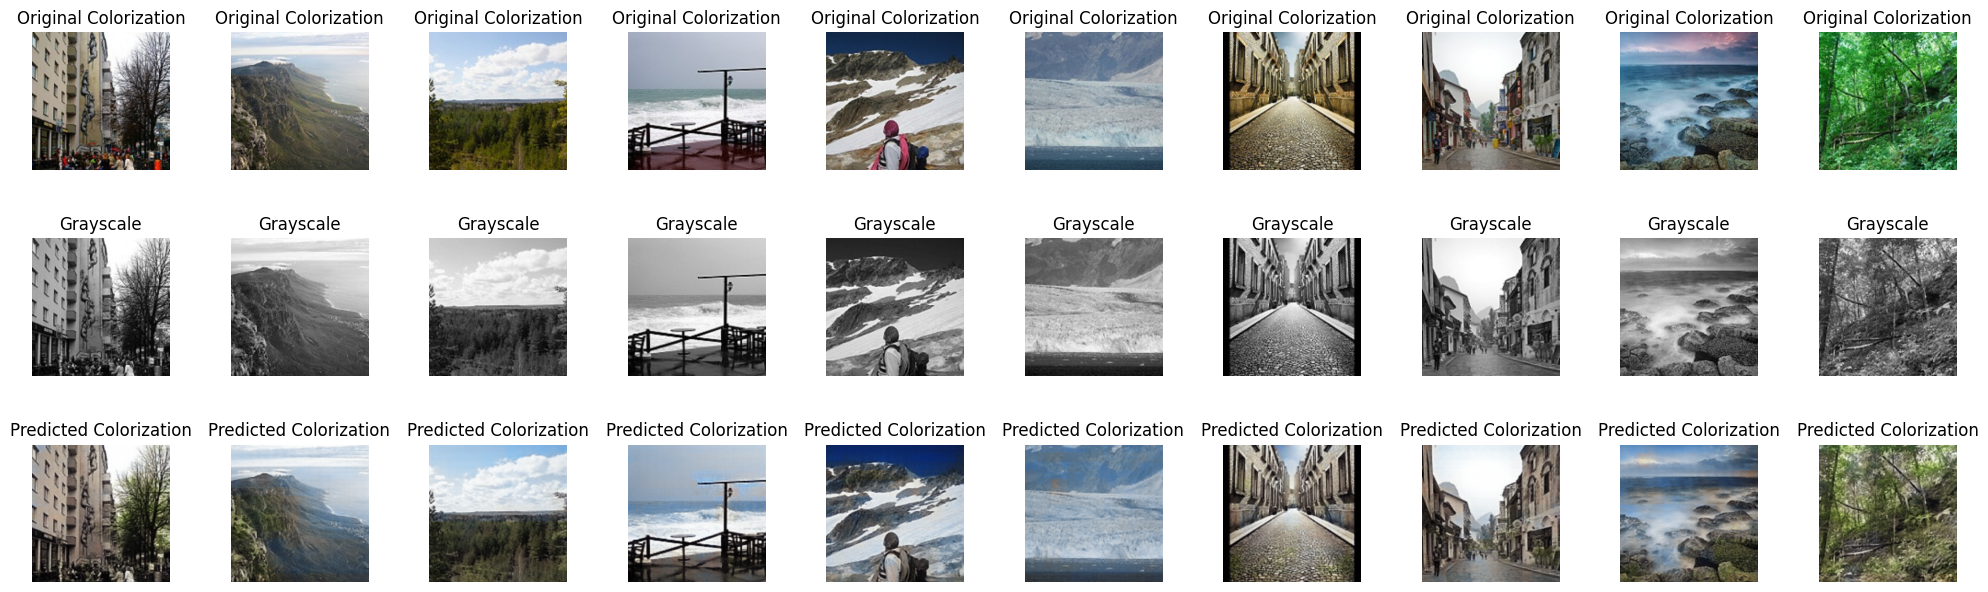

In [14]:
with torch.no_grad():
    for gray_images, color_images in test_loader:
        gray_images = gray_images.to(device)
        color_images = color_images.to(device)
        outputs = model(gray_images)
        break

gray_images = gray_images.detach().cpu()
color_images = color_images.detach().cpu()
outputs = outputs.detach().cpu()

fig, axs = plt.subplots(3, 10, figsize=(20,6))

for i in range(10):
    axs[0, i].imshow(np.transpose(color_images[i], (1, 2, 0)))
    axs[0, i].axis('off')
    axs[0, i].set_title('Original Colorization')

    axs[1, i].imshow(np.transpose(gray_images[i], (1, 2, 0)).numpy().squeeze(), cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title('Grayscale')

    axs[2, i].imshow(np.transpose(outputs[i], (1, 2, 0)))
    axs[2, i].axis('off')
    axs[2, i].set_title('Predicted Colorization')

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

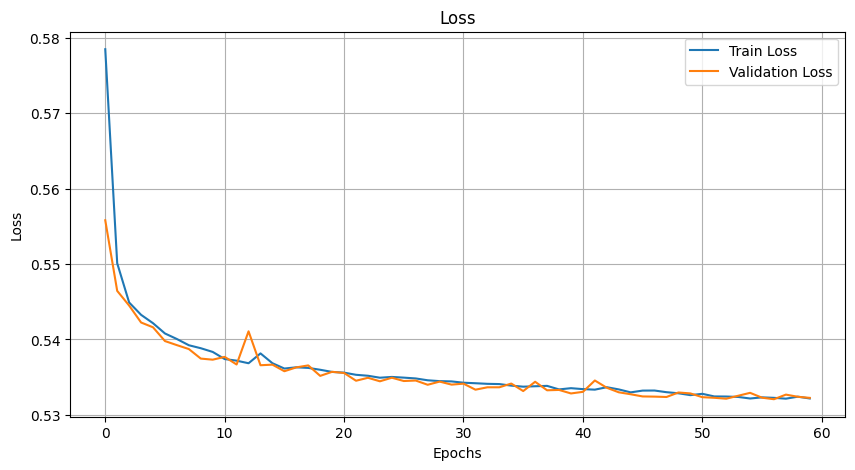

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

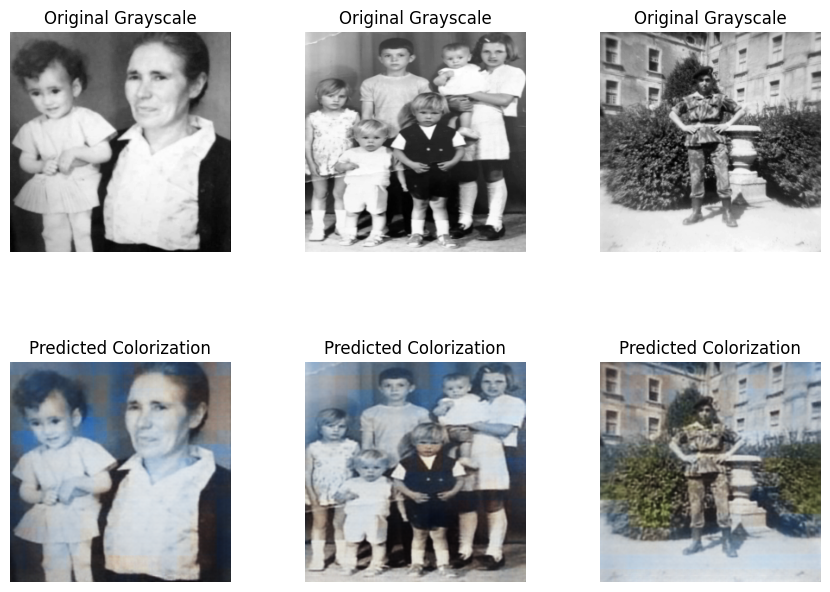

In [16]:
with torch.no_grad():
    for images in family_loader:
        images = images.to(device)
        family_outputs = model(images)
        break

family_images = images.detach().cpu()
family_outputs = family_outputs.detach().cpu()

fig, axs = plt.subplots(2, 3, figsize=(9,6))

for i in range(3):
    axs[0, i].imshow(family_images[i].squeeze(), cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title('Original Grayscale')

    axs[1, i].imshow(np.transpose(family_outputs[i], (1, 2, 0)))
    axs[1, i].axis('off')
    axs[1, i].set_title('Predicted Colorization')

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()